In [225]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

***Projected Subgradient Method***

In [226]:
def read_data(verbose=False):

    data = pd.read_csv("all_stocks_5yr.csv")
    df = data[["date", "Name", "close"]]

    prices = df.pivot(index="date", columns="Name", values="close")
    prices = prices.dropna(axis=1)

    # with open("prices.txt", "w") as f:
    #     f.write(prices.to_string())
    #     f.close()

    returns = prices.pct_change().dropna()
    # with open("rendements.txt", "w") as f:
    #     f.write(returns.to_string())
    #     f.close()


    X = returns.values
    mu = returns.mean().values
    Sigma = returns.cov().values


    if verbose:
        print("X shape =", X.shape)
        print("mu shape =", mu.shape)
        print("Sigma shape =", Sigma.shape)
    
    return X, mu, Sigma



In [227]:
def projection_on_simplex(v):
    """
    Project a vector v onto the simplex:
        Δ = { w >= 0, sum(w) = 1 }
    """
   
    u = sorted(v, reverse=True)
    cumulative_sum = np.cumsum(u)

    thetas = (cumulative_sum - 1) / (np.arange(1, len(v) + 1))
    k = np.where(u - thetas > 0)[0].max()

    theta = (cumulative_sum[k] - 1) / (k + 1)
    w = np.maximum(v - theta, 0)

    return w

def test(): 
    v = np.array([0.9, 0.9, 0.2])
    v2 = -1 * v

    print("w1 : ", projection_on_simplex(v))
    print("w2 : ", projection_on_simplex(v2))

#test()

def sign(v):
    result = np.zeros_like(v)

    result[v > 0] = 1
    result[v < 0] = -1

    return result


def obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c):

    return 0.5 * w.T @ Sigma @ w -lam * (mu @ w) + \
            c * np.sum(np.abs(w - wprev))

def projected_subgradient_method(lam, c, Sigma, mu, wprev, alpha0=0.1, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    k = 0

    obj_values = []
    for k in tqdm(range(max_iter)):

        obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        g = Sigma @ w - lam * mu + c * np.sign(w - wprev)
        step_size = alpha0 / (k + 1)
        w_new = projection_on_simplex(w - step_size * g)
        
        if (np.linalg.norm(w_new - w) < tol):
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
       # plt.yscale("log")
        plt.ylabel("Objective value")
        plt.title("Convergence of Projected Subgradient Method")
        plt.show()
       
    
    return w, obj_values




    

X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)
min eigenvalue: 5.277166333654771e-06


100%|██████████| 50000/50000 [00:15<00:00, 3150.48it/s]


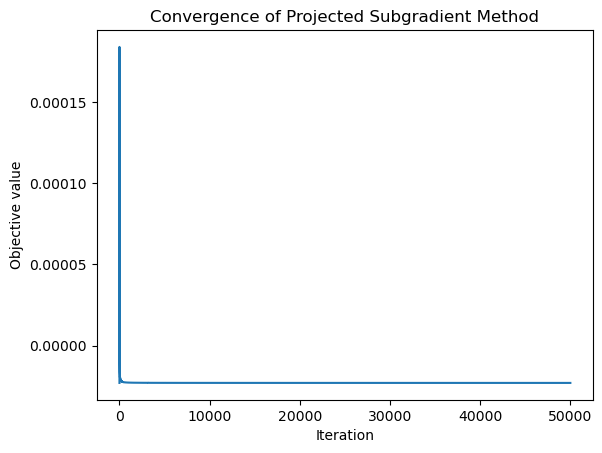

Sum of weights: 0.9999999999999998
Converged objective value: -2.2967737312151216e-05


In [228]:
X, mu, Sigma = read_data(verbose=True)
eigvals = np.linalg.eigvalsh(Sigma)
print("min eigenvalue:", eigvals.min())
lam = 0.1
c = 0.003
wprev = np.ones(X.shape[1]) / X.shape[1]

w = projected_subgradient_method(lam, c, Sigma, mu, wprev, tol= 1e-8, plot=True)[0]
#print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

***Proximal gradient method***

In [230]:
def prox(wprev, step_size, v, c):
    return wprev + sign(v - wprev) * np.maximum(np.abs(v - wprev) - c * step_size, 0)


def proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    step_size = 1/L
    
    obj_values = []

    print("c * step_size =", c * step_size)
    
    for k in tqdm(range(max_iter)):

        obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        v = w - step_size * (Sigma @ w - lam * mu)
        u = prox(wprev, step_size, v, c)
        w_new = projection_on_simplex(u)
        # if k == 0:
        #     print("norm(v-w):", np.linalg.norm(v - w))
        #     print("c/L:", c / L)
        #     print("max(|v-w|):", np.max(np.abs(v - w)))
        
        if (np.linalg.norm(w_new - w) < tol) and k > -5000:
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values_proximal.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value ")
        plt.title("Convergence of Proximal Gradient Method")
        plt.show()
    
    return w, obj_values

    

max(grad f(wprev) 0.00019940254441164733
c * step_size = 0.09164453155935198


  0%|          | 0/50000 [00:00<?, ?it/s]

Converged in 0 iterations.


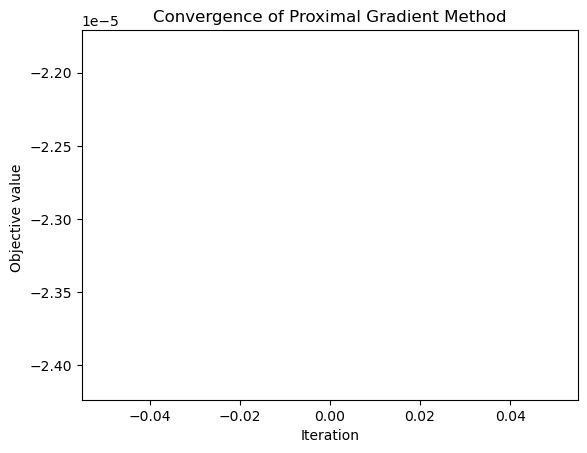

Sum of weights: 0.9999999999999999
Converged objective value: -2.2971838159700615e-05
-2.2971838159700615e-05


In [231]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.003
#c = 0.00001
L = np.linalg.eigvalsh(Sigma).max()
wprev = np.ones(X.shape[1]) / X.shape[1]
print("max(grad f(wprev)", max(Sigma @ wprev - mu * lam))
w = proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=True)[0]
#print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

print(obj_f_nonSmooth(wprev, wprev, Sigma, mu, lam, c))

***Long-Step Path-Following Interior-Point method***

In [233]:
def f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    quad = 0.5 * w @ (Sigma @ w)
    lin  = - lam * (mu @ w)
    l1   = c * np.sum(t)

    f = (quad + lin + l1) / mu_k

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    barrier = - np.sum(np.log(w)) \
              - np.sum(np.log(a)) \
              - np.sum(np.log(b))

    return f + barrier


def grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    a = t - (w - w_prev)
    b = t + (w - w_prev)

    grad_w = (Sigma @ w - mu * lam) / mu_k \
             - 1.0/w \
             + 1.0/a \
             - 1.0/b

    grad_t = (c / mu_k) * np.ones_like(t) \
             - 1.0/a \
             - 1.0/b

    return np.concatenate([grad_w, grad_t])


def hess_f_mu(w, t, mu_k, Sigma, w_prev):
    n = len(w)

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    H = np.zeros((2*n, 2*n))

    # H_ww
    H_ww = Sigma / mu_k
    H_ww = H_ww + np.diag(1/w**2 + 1/a**2 + 1/b**2)
    H_tt = np.diag(1/a**2 + 1/b**2)
    H_wt = np.diag(-1/a**2 + 1/b**2) 
    
    H = np.block([
        [H_ww, H_wt],
        [H_wt, H_tt]
    ])

    return H

# def delta(w, t, mu_k, Sigma, mu, lam, c, w_prev):
#     g = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)
#     H = hess_f_mu(w, t, mu_k, Sigma, w_prev)
#     v = np.linalg.solve(H, g)
#     return np.sqrt(g @ v)

def delta(w, t, mu_k, Sigma, mu, lam, c, w_prev):

    n = len(w)

    grad = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)

    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)

    A = np.zeros((1, 2*n))
    A[0, :n] = 1.0

    KKT = np.block([
        [H, A.T],
        [A, np.zeros((1,1))]
    ])

    rhs = -np.concatenate([grad, np.zeros(1)])

    sol = np.linalg.solve(KKT, rhs)
    dx = sol[:2*n]

    return np.sqrt(-grad @ dx)


def newton_direction(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    n = len(w)

    g = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)

    A = np.zeros((1, 2*n))
    A[0, :n] = 1.0

    KKT = np.block([
        [H, A.T],
        [A, np.zeros((1,1))]
    ])

    rhs = -np.concatenate([g, np.zeros(1)])

    sol = np.linalg.solve(KKT, rhs)
    dx = sol[:2*n]

    dw = dx[:n]
    dt = dx[n:]

    return dw, dt


def damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    dw, dt = newton_direction(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)

    alpha = 1.0 / (1.0 + d)

    return w + alpha * dw, t + alpha * dt


def initialization(w_start, t_start, mu_k, tau, Sigma, mu, lam, c, w_prev):

    w = w_start.copy()
    t = t_start.copy()

    d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    k = 0
    while d >= tau:
        
        w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev)
        #print(f"Initialization iteration {k}, delta = {d}, w-min = {np.min(w)}, t-min = {np.min(t)}")
        d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)
        k += 1

        if k > 500:
            break

    return w, t


def LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta,
              nu, max_iter=500, tol=1e-8, plot=False):

    mu_k = 0.01
    n = len(wprev)
    w_start = np.ones(n) / n
    t_start = np.abs(w_start - wprev) + 1.0

    
    obj_values = []

    print("Initializing...")
    w, t = initialization(w_start, t_start, mu_k, tau, Sigma, mu, lam, c, wprev)
    print("Initialization done.")
    mu_final = tol * (1 - tau) / nu

    k = 1

    while mu_k > mu_final:
        
        obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        if k > max_iter:
            print("Maximum iterations reached.")
            break

        while delta(w, t, mu_k, Sigma, mu, lam, c, wprev) >= tau:
            w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, wprev)
        
        mu_k = (1 - theta) * mu_k
        k += 1
        print(k)
        #print(f"mu_k = {mu_k}; mu_final = {mu_final}")

    print(f"Converged in {k} iterations.")

    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value")
        plt.title("Convergence of LS PF IPM")
        plt.show()
    return w, obj_values


Initializing...
Initialization done.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
Converged in 134 iterations.


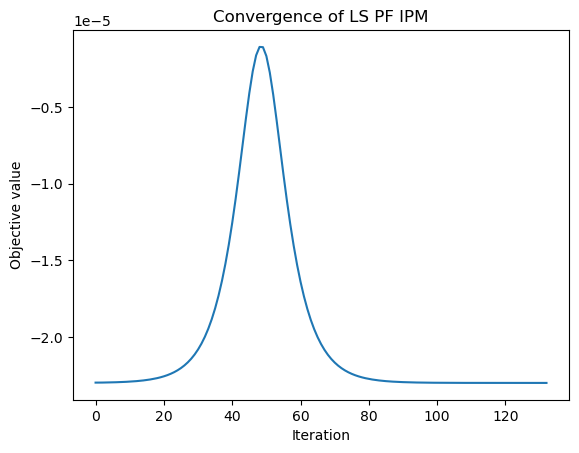

Sum of weights: 0.9999999999999999


In [234]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.003
wprev = np.ones(X.shape[1]) / X.shape[1]
tau = 0.35
theta = 0.15
nu = 3*len(wprev)

w_IPM = LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta, nu, max_iter=500, tol= 1e-8, plot=True)[0] 
#print("Optimal weights:", w_IPM)
print("Sum of weights:", np.sum(w))
f_IPM = obj_f_nonSmooth(w_IPM, wprev, Sigma, mu, lam, c)
#print("Converged objective value:", f_IPM)

100%|██████████| 50000/50000 [00:17<00:00, 2811.20it/s]


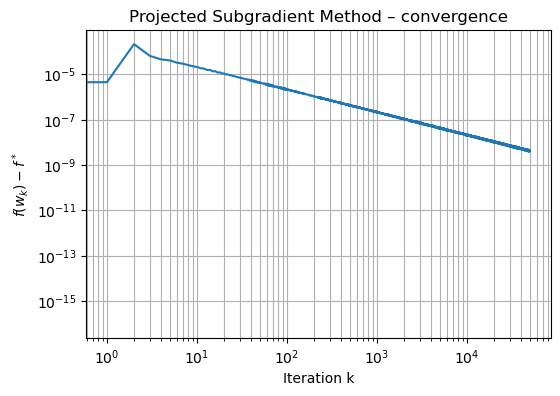

In [235]:

w_ref = w_IPM
f_ref = f_IPM

f_vals = projected_subgradient_method(lam, c, Sigma, mu, wprev, tol=1e-8, plot=False)[1]
err = f_vals - f_ref
err = np.maximum(err, 1e-16)

#print(err)

plt.figure(figsize=(6,4))
plt.loglog(err)
plt.xlabel("Iteration k")
plt.ylabel(r"$f(w_k) - f^*$")
plt.title("Projected Subgradient Method – convergence")
plt.grid(True, which="both")
plt.show()

In [236]:
k = np.arange(1, len(err) + 1)

logk = np.log(k)
logerr = np.log(err)

start = len(k) // 4
coef = np.polyfit(logk[start:], logerr[start:], 1)

print("Estimated slope:", coef[0])

Estimated slope: -1.0063739796036368


In [237]:
def obj_f_Smooth(w, Sigma, mu, lam):

    return 0.5 * w.T @ Sigma @ w -lam * (mu @ w) 

***PROJECTED GRADIENT DESCENT***


In [238]:
def projected_gradient_method(lam,Sigma, mu, max_iter=50000, tol= 1e-8, plot=False): 

    n = Sigma.shape[0]  
    w = np.ones(n) / n  
    L= np.max(np.linalg.eigvals(Sigma))
    step_size = 1 / L
       
   
    if plot:
        obj_values = []
        
    obj_old = obj_f_Smooth(w, Sigma, mu, lam)

    for k in tqdm(range(max_iter)):
    
        if plot:
            obj_values.append(obj_old)
    
        # Compute the gradient
        g = Sigma @ w - lam * mu
    
        #  Gradient step and projection
        w_new = projection_on_simplex(w - step_size * g)
    
        # Evaluate new objective
        obj_new = obj_f_Smooth(w_new, Sigma, mu, lam)
    
        # Check stopping criterion based on objective change
        if abs(obj_new - obj_old) < tol:
            print(f"Converged in {k} iterations.")
            w = w_new
            break
    
        # Update iterate and objective
        w = w_new
        obj_old = obj_new

    with open("values_PDG.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        
        plt.ylabel("Objective value ")
        plt.title("Convergence of Projected gradient Method")
        plt.show()
    
    return w 


X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


 13%|█▎        | 192/1500 [00:00<00:00, 3691.53it/s]

Converged in 192 iterations.


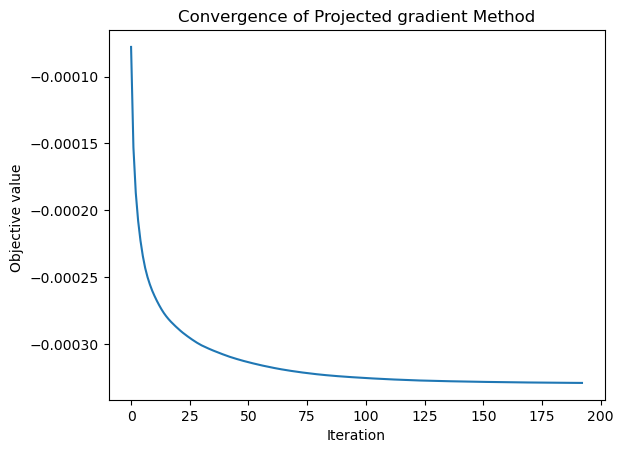

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10072615 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.03094915 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

In [212]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.2  # TO ADJUCT ACCORDING IF WNT A RISKY OR LESS RISKY PORTFOLIO

w = projected_gradient_method(lam, Sigma, mu,max_iter=1500, tol=1e-8, plot=True)
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_Smooth(w, Sigma, mu, lam))

***PROJECTED GRADIENT DESCENT WITH MOMENTUM***

In [213]:
def projected_gradient_momentum_method(beta, lam, Sigma, mu, max_iter=50000, tol=1e-8, plot=False): 
    
    n = Sigma.shape[0]  
    w = np.ones(n) / n  
    w_old = w.copy()
    L = np.max(np.linalg.eigvals(Sigma))
    step_size = 1 / L
       
    obj_values = []
    obj_old = obj_f_Smooth(w, Sigma, mu, lam)

    for k in tqdm(range(max_iter)):
        
        # Compute gradient
        g = Sigma @ w - lam * mu
        
        # Gradient step with momentum
        if k == 0:
            w_momentum = w - step_size * g
        else:
            w_momentum = w - step_size * g + beta * (w - w_old)
        
        # Projection
        w_new = projection_on_simplex(w_momentum)
        
        # Evaluate objective
        obj_new = obj_f_Smooth(w_new, Sigma, mu, lam)
        obj_values.append(obj_new)

        # Convergence check
        if np.abs(obj_new - obj_old) < tol:
            w = w_new
            print(f"Converged in {k+1} iterations.")
            break
    
        # Update iterate
        w_old = w
        w = w_new
        obj_old = obj_new

    # Save values
    with open("values_PDGM.txt", "w") as f:
        f.write(str(obj_values))

    # Plot
    if plot:
        plt.plot(obj_values)
  
        plt.xlabel("Iteration")
        plt.ylabel("Objective value")
        #plt.yscale("log")
        plt.title("Convergence of Projected Gradient Method with Momentum")
        plt.show()
    
    return w


X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


  0%|          | 29/50000 [00:00<00:15, 3185.74it/s]

Converged in 30 iterations.


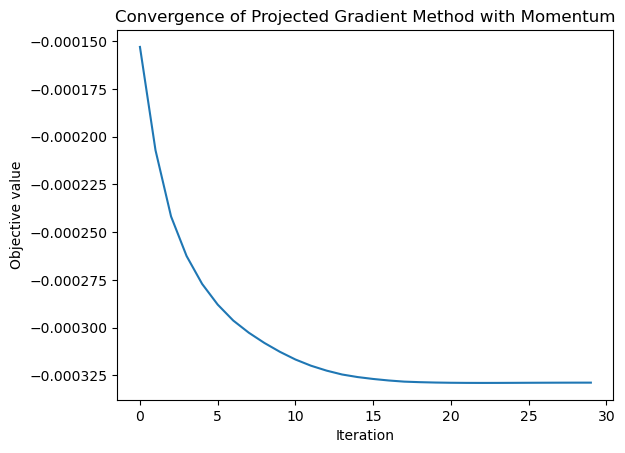

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.08540791 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00425637 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

In [214]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.2   # TO ADJUCT ACCORDING IF WNT A RISKY OR LESS RISKY PORTFOLIO
beta =  0.9  # TO ADJUST

w = projected_gradient_momentum_method(beta, lam, Sigma, mu, max_iter=50000, tol=1e-8, plot=True)
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_Smooth(w, Sigma, mu, lam))





***PROJECTED RANDOMIZED DESCENT***

In [215]:
def projected_randomized_method(lam, Sigma, mu, max_iter=50000, plot=False):
    """
    Projected Randomized Coordinate Descent for smooth mean-variance model.
    
    Stopping criteria:
        - Fixed number of iterations (max_iter)
        - Optional: monitor gradient norm for convergence analysis
    
    Note: The objective function may not decrease monotonically at each iteration
          because only one coordinate is updated at a time, and projection onto
          the simplex can locally increase the objective.
    """
    n = Sigma.shape[0]
    w = np.ones(n) / n  # Initialize uniformly
    L = np.max(np.linalg.eigvals(Sigma))
    step_size = 1 / L

    obj_values = [obj_f_Smooth(w, Sigma, mu, lam)] if plot else None
    grad_norms = []

    for k in tqdm(range(max_iter)):
        # Compute gradient
        g = Sigma @ w - lam * mu

        # Pick one coordinate randomly
        i = np.random.randint(0, n)
        g_random = np.zeros_like(g)
        g_random[i] = g[i]

        # Gradient step + projection
        w_new = projection_on_simplex(w - step_size * g_random)
        w = w_new

        if plot:
            obj_values.append(obj_f_Smooth(w, Sigma, mu, lam))
            grad_norms.append(np.linalg.norm(g))

    # Plot objective function and gradient norm if requested
    if plot:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        plt.ylabel("Objective value")
        plt.title("Convergence of Randomized Coordinate Descent")
        plt.grid(True)

        

    return w

X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


100%|██████████| 5000/5000 [00:01<00:00, 3241.73it/s]

Optimal weights: [0.00000000e+00 1.93291262e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.09734326e-03 1.00609805e-03 0.00000000e+00
 8.59620533e-03 0.00000000e+00 0.00000000e+00 9.65986893e-04
 0.00000000e+00 5.63378036e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.11554338e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.55984579e-03 0.00000000e+00
 1.03550869e-03 9.54455383e-04 2.01298789e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.23622137e-03 6.71167890e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.10003434e-02 0.00000000e+00 0.00000000e+00
 2.04820174e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.88452070e-02 0.00000000e+00 3.96932848e-02
 2.08970030e-03 4.15573499e-04 0.00000000e+00 1.18486171e-03
 3.50423497e-04 2.90222372e-02 2.67746670e-03 0.00000000e+00
 0.00000000e+00 4.14517917e-02 0.00000000e+00 0.00000000e+00
 2.0171

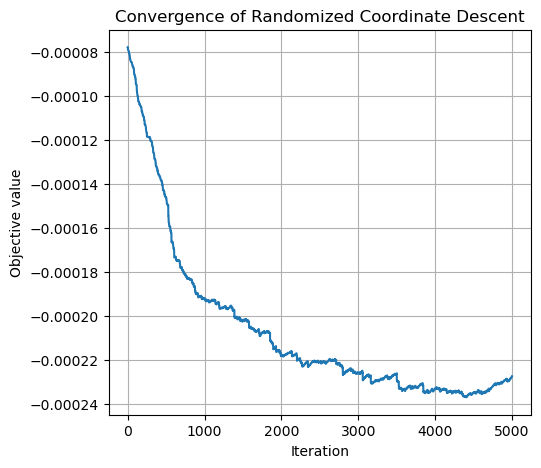

In [216]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.2   # TO ADJUCT ACCORDING IF WNT A
w = projected_randomized_method(lam, Sigma, mu, max_iter=(5000), plot=True)

print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_Smooth(w, Sigma, mu, lam))

